In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time


#I/O 
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
VIPA_filename       =   'NO_ARS_12_02_VIPA_quasisat.tif'
log_file            =   'log_'+spectra_filename
analysis_dir        =   'analysis/'

#operatives

#esclusi a mano
to_add              =   []

syg_kwargs          =   {'height': 119, 'distance': 31, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':70, 'width': 1}
syg_kwargs_brill    =  {'height': 23, 'distance': 31, 'width': 3.}
VIPA_treshold       =   6
sat_height          =   50000
sat_width           =   13.5
almost_treshold     =   15000

#quanto mi allontano dal VIPA
pre_cut             =   False
cut                 =   True

mean_dist_01 = 37
mean_dist_23 = 34
#markov_fit
p0_normal = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.448930518e-01,  8.34614271,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_brillouin = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.48930518e-01,  2.34614271e-01,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_almost = np.array([ 1.07186924e-01,  7.63051819e+00,  1.33280055e-01,  1.97510814e+00,
        5.09986043e-01,  1.66616101e+00,  4.33362727e+03, -1.00496864e+01,
        1.59365161e+01,  2.77695117e-01,  6.43211621e+00])

recover_markov = False
rules_markov_bounds     =   ('positive', 0.2, 'positive', [-2,2] , 'positive', 'positive', 0.2, 0.01, 0.001,  'inf', 'inf')
#tot fit
skip_tot = False
rules_tot_bounds                   =   (0.2, 0.01, 0.01, 'positive', 'positive', [-2,2], 0.01, 0.01, 'inf', 'inf')
############



cols_smart  =  ('Co', 'Omega', 'Gamma', 'delta_position',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

#markov_fit
p0_normal = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.448930518e-01,  8.34614271,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_brillouin = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.48930518e-01,  2.34614271e-01,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_almost = np.array([ 1.07186924e-01,  7.63051819e+00,  1.33280055e-01,  1.97510814e+00,
        5.09986043e-01,  1.66616101e+00,  4.33362727e+03, -1.00496864e+01,
        1.59365161e+01,  2.77695117e-01,  6.43211621e+00])

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


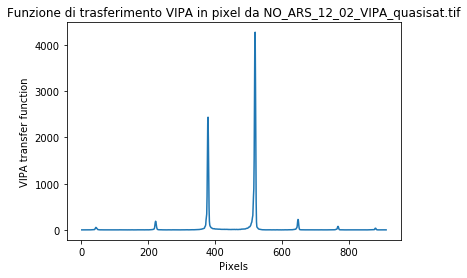

Text(0.5, 1.0, '(78, 26)')

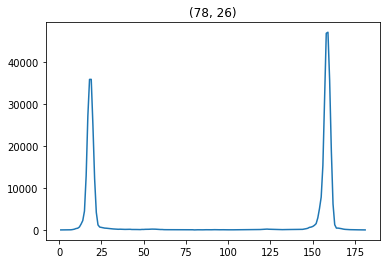

In [2]:
#0) importo dati e inizializzo oggetti
i   =   78
j   =   26
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Lo spettro è almost_height
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(78, 26)')

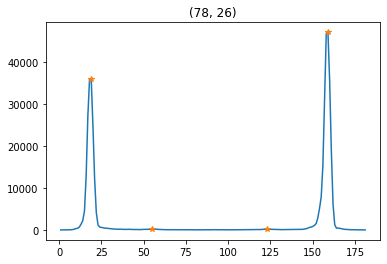

In [3]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    if (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][1]]) & (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][3]]):
        nature    = 'brillouin_highest_dx'
    elif (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][2]]) & (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][0]]):
        nature    = 'brillouin_highest_sx'
    else:
        raise ValueError ('Non ho riconosciuto lo spettro\n')

elif (Data.n_peaks == 3) :
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

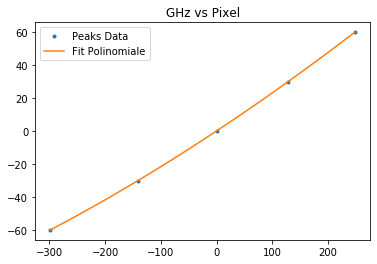

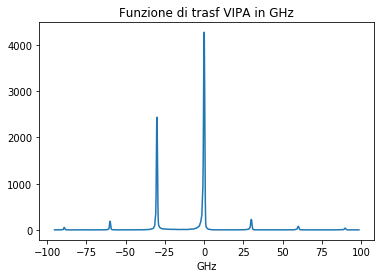

In [4]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)


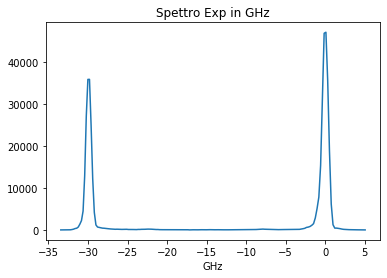

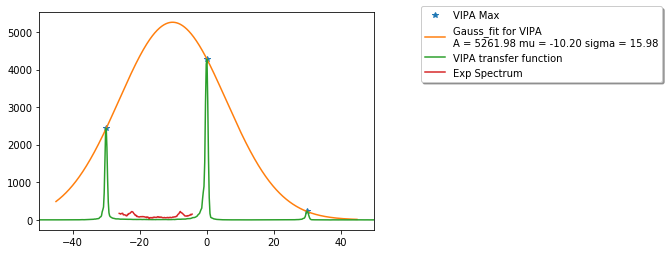

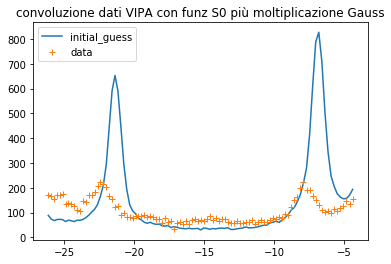

In [5]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive
Data.Align_Spectrum()
Data.Spectrum_Pix2GHz(fig = True)
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = cut, mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23, verbose = True)
Data.Fit_VIPA_Gaussian(fig = True)
p0 = Data.p0[list(cols_mark)].values[0]
#p0 = np.array([ 1.00000000e+00,  7.58814822e+00,  1.00000000e-01,  0.00000000e+00,        1.00000000e-01,  1.00000000,  5.26197998e+03, -1.02027273e+01,     1.59764572e+01,  0.00000000e+00,  0.00000000e+00])
_ = Data.Gauss_Convolve_Markovian_Response(p0, fig = True, compare = True)

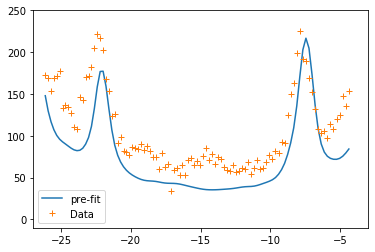

In [7]:
p0 = np.array([ 1.08633225e-01,  7.70983143e+00,  1.58967633e-01,  1.70455195e+00,
        6.40427573e-01,  2.20351667e+00,  5.23638443e+03, -10.18245455e+00,
        1.5973788115e+01,  2.73907418e-01,  8.73821212e+00])
plt.figure()
plt.plot(Data.x_freq, Data.Gauss_Convolve_Markovian_Response_Fast(p0), label = 'pre-fit' )
plt.plot(Data.x_freq, Data.y, '+', label = 'Data')
plt.xlim(-27, -3)
plt.ylim(-10, 250)
plt.legend()


Cost before fitting = 4988.0661813668685
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9881e+03                                    2.24e+04    
       1              3         5.2299e+02      4.47e+03       4.15e+01       6.79e+02    
       2              7         3.8546e+02      1.38e+02       1.41e+00       2.60e+03    
       3              9         3.2444e+02      6.10e+01       6.99e-01       9.81e+03    
       4             10         2.8729e+02      3.72e+01       1.35e+00       4.07e+03    
       5             11         2.7772e+02      9.57e+00       3.87e+01       4.77e+01    
       6             14         2.7756e+02      1.56e-01       1.37e+00       1.01e+02    
       7             16         2.7755e+02      8.75e-03       7.71e-01       5.02e+01    
       8             18         2.7755e+02      9.90e-04       6.52e-01       7.49e+00    
       9             20         2.7755e+02      5

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.095943,7.712467,0.157558,-0.012396,0.085955,1.234909e+01,5.223140e+03,-10.049686,15.936516,-0.010159,45.347279
StdErrs,0.384435,0.030102,0.024486,78690.677424,249581.818360,1.533849e+07,5.899682e+09,59.599739,94.140588,0.030762,2.195628
Initials,0.010000,7.259927,0.100000,0.000000,0.100000,1.000000e+00,5.261980e+03,-10.202727,15.976457,0.000000,0.000000


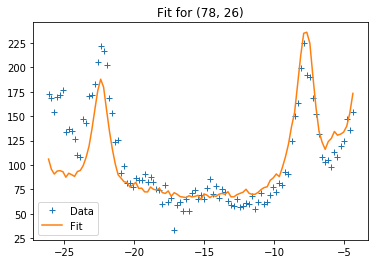

In [8]:
#3) fit markoviano
rules_markov_bound     =   ('positive', 0.2, 'positive', [-2,2], 'positive', 'positive', 0.2, 0.015, 0.0025, 'inf', 'inf')

p0s = [Data.p0[list(cols_mark)].values[0], p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, cols_mark)
Data.Get_cost_markov(Data.p0[list(cols_mark)].values[0], columns = cols_mark)
print('Cost before fitting = {}'.format(Data.cost_markov))
Data.Get_Fit_Bounds(rules_markov_bound, cols_mark)
_= Data.Non_Linear_Least_Squares_Markov(cols_mark, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, fig = True, zoom = False)
#_ = Data.Non_Linear_Least_Squares_Markov(bound = (Data.bounds['down'].values, Data.bounds['up'].values),  max_nfev = 500)
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = cols_mark)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [9]:
Data.p0.T.Values[list(cols_gauss)] = np.array([23, 12, 3])

Co     Omega  Gamma  delta_position  delta_width  delta_amplitude  \
Values  0.01  7.259927    0.1             0.0          0.1                1   

                  A         mu      sigma  shift  offset  
Values  5261.979978 -10.202727  15.976457    0.0       0  
               Co    Omega     Gamma delta_position delta_width  \
Values  0.0959429  7.71247  0.157558     -0.0123955   0.0859547   

       delta_amplitude        A       mu    sigma      shift   offset  
Values         12.3491  5223.14 -10.0497  15.9365 -0.0101587  45.3473  
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3662e+02                                    7.66e+01    
       1              2         4.5765e+02      1.79e+02       1.61e+01       2.27e+01    
       2              3         4.4957e+02      8.07e+00       2.24e+00       1.58e+01    
       3              4         4.4518e+02      4.39e+00       1.05e+01       1.33e+01    

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.108402,7.635348,0.159133,2.879130,312.315090,2.000000,0.085095,12.225604,0.002150,61.308949
StdErrs,0.088066,6.241699,0.123757,4642.674104,925718.360625,8.983410,0.303815,17.660141,0.027601,37.308711
Initials,0.095943,7.712467,0.157558,0.157558,1.000000,-0.012396,0.085955,12.349095,-0.010159,45.347279


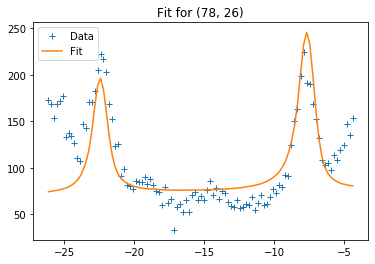

In [10]:
#4) fit totale
rules_tot_bounds                    =   (0.2, 0.01, 0.01, 'positive', 'positive', [-2,2], 0.01, 0.01, 'inf', 'inf')
print(Data.p0[list(cols_mark)])
Data.Initials_Parameters_from_Markov(Data.Markov_Fit_Params, cols_mark)
print(Data.p0[list(cols_mark)])
Data.Get_Fit_Bounds(rules_tot_bounds, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
#Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)
Data.Tot_Fit_Params

In [11]:
Data.Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.095943,7.712467,0.157558,-0.012396,0.085955,1.234909e+01,5.223140e+03,-10.049686,15.936516,-0.010159,45.347279
StdErrs,0.384435,0.030102,0.024486,78690.677424,249581.818360,1.533849e+07,5.899682e+09,59.599739,94.140588,0.030762,2.195628
Initials,0.010000,7.259927,0.100000,0.000000,0.100000,1.000000e+00,5.261980e+03,-10.202727,15.976457,0.000000,0.000000


In [12]:
Data.Tot_Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.108402,7.635348,0.159133,2.879130,312.315090,2.000000,0.085095,12.225604,0.002150,61.308949
StdErrs,0.088066,6.241699,0.123757,4642.674104,925718.360625,8.983410,0.303815,17.660141,0.027601,37.308711
Initials,0.095943,7.712467,0.157558,0.157558,1.000000,-0.012396,0.085955,12.349095,-0.010159,45.347279


In [13]:
Data.Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.095943,7.712467,0.157558,-0.012396,0.085955,1.234909e+01,5.223140e+03,-10.049686,15.936516,-0.010159,45.347279
StdErrs,0.384435,0.030102,0.024486,78690.677424,249581.818360,1.533849e+07,5.899682e+09,59.599739,94.140588,0.030762,2.195628
Initials,0.010000,7.259927,0.100000,0.000000,0.100000,1.000000e+00,5.261980e+03,-10.202727,15.976457,0.000000,0.000000


In [14]:
p0  = Data.p0
Markov_Fit_Params = Data.Markov_Fit_Params
p0

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.0959429,7.71247,0.157558,0.157558,1.0,-0.0123955,0.0859547,12.3491,5223.14,-10.0497,15.9365,-0.0101587,45.3473


In [15]:
p0[list(cols_mark)].update(Markov_Fit_Params)
p0

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.0959429,7.71247,0.157558,0.157558,1.0,-0.0123955,0.0859547,12.3491,5223.14,-10.0497,15.9365,-0.0101587,45.3473


In [16]:
p0

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.0959429,7.71247,0.157558,0.157558,1.0,-0.0123955,0.0859547,12.3491,5223.14,-10.0497,15.9365,-0.0101587,45.3473
